In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [ ]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

In [ ]:
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100

In [ ]:
def generateBatchBipolar(n, mu=0.5, sigma=0.2):
    """ Two gaussian clouds on each side of the origin """
    X = np.random.normal(mu, sigma, (n, 2))
    yB = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y = 2. * yB - 1
    X *= y[:, np.newaxis]
    X -= X.mean(axis=0)
    return X, y

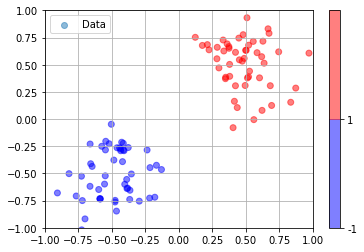

In [ ]:
xTrain0, yTrain0 = generateBatchBipolar(N, sigma=0.2)
plotSvm(xTrain0, yTrain0)

In [ ]:
class MaxMarginClassifier:
    
    def __init__(self):
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (X.y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = -np.eye(N)
        b = np.zeros(N)
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        # Any support vector is at a distance of 1 to the separation plan
        # => use support vector #0 to compute the intercept, assume label is in {-1, 1}
        supportLabels = y[self.alpha > epsilon]
        self.intercept = supportLabels[0] - np.matmul(self.supportVectors[0].T, self.w)
    
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * (np.matmul(X, self.w) > 0) - 1

In [ ]:
model00 = MaxMarginClassifier()
model00.fit(xTrain0, yTrain0)
model00.w, model00.intercept

(array([2.61498613, 1.56081294]), 0.06227809531164019)

Number of support vectors = 3


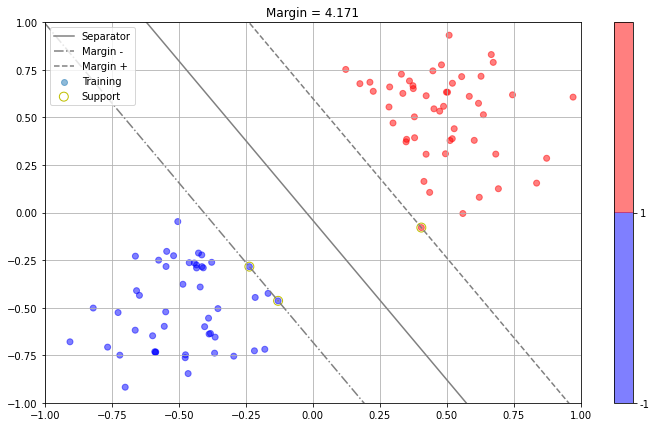

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(xTrain0, yTrain0, model00.supportVectors, model00.w, model00.intercept, label='Training', ax=ax)

In [ ]:
model01 = svm.SVC(kernel='linear', gamma='auto', C = 1e6)
model01.fit(xTrain0, yTrain0)
model01.coef_[0], model01.intercept_[0]

(array([2.61521044, 1.56090303]), 0.06200315545329174)

Number of support vectors = 3


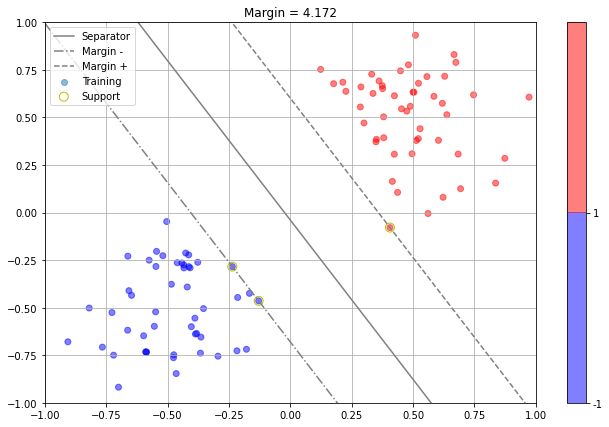

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain0, yTrain0, model01.support_vectors_, model01.coef_[0], model01.intercept_[0], 
        label='Training', ax=ax)

In [ ]:
model02 = linear_model.LogisticRegression(solver='lbfgs')
model02.fit(xTrain0, yTrain0)
model02.coef_[0], model02.intercept_[0]

(array([2.9781238 , 2.72683069]), -0.03255240388280588)

In [ ]:
model03 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model03.fit(xTrain0, yTrain0)
model03.coef_[0], model03.intercept_[0]

(array([32.60073143, 19.92544751]), -3.552713678800501e-15)

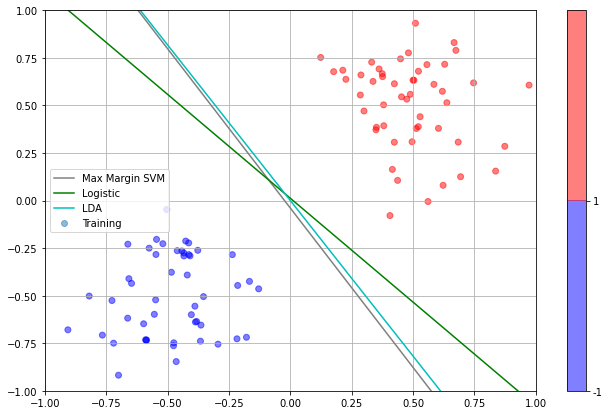

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain0, yTrain0, w=model01.coef_[0], intercept=model01.intercept_[0], 
        separatorLabel='Max Margin SVM', label='Training', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model02.coef_[0], x0=model02.intercept_[0], label='Logistic', color='g')
plotLine(ax, xx, w=model03.coef_[0], x0=model03.intercept_[0], label='LDA', color='c')
ax.legend();

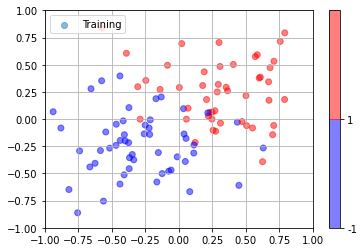

In [ ]:
xTrain1, yTrain1 = generateBatchBipolar(N, mu=0.3, sigma=0.3)
plotSvm(xTrain1, yTrain1, label='Training')

In [ ]:
class LinearSvmClassifier:
    
    def __init__(self, C):
        self.C = C                                 # <---
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (X.y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        # Support vectors is at a distance <= 1 to the separation plan
        # => use min support vector to compute the intercept, assume label is in {-1, 1}
        signedDist = np.matmul(self.supportVectors, self.w)
        minDistArg = np.argmin(signedDist)
        supportLabels = y[self.alpha > epsilon]
        self.intercept = supportLabels[minDistArg] - signedDist[minDistArg]
    
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * (np.matmul(X, self.w) > 0) - 1

In [ ]:
model10 = LinearSvmClassifier(C=1)
model10.fit(xTrain1, yTrain1)
model10.w, model10.intercept

(array([2.39714603, 2.84113186]), -0.009631996323303471)

Number of support vectors = 40


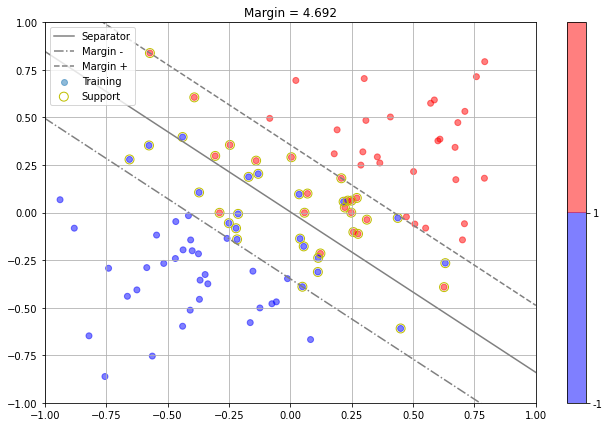

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, model10.supportVectors, model10.w, model10.intercept, label='Training', ax=ax)

In [ ]:
model11 = svm.SVC(kernel='linear', gamma='auto', C = 1)
model11.fit(xTrain1, yTrain1)
model11.coef_[0], model11.intercept_[0]

(array([2.39950903, 2.84153521]), -0.009809472432858242)

Number of support vectors = 40


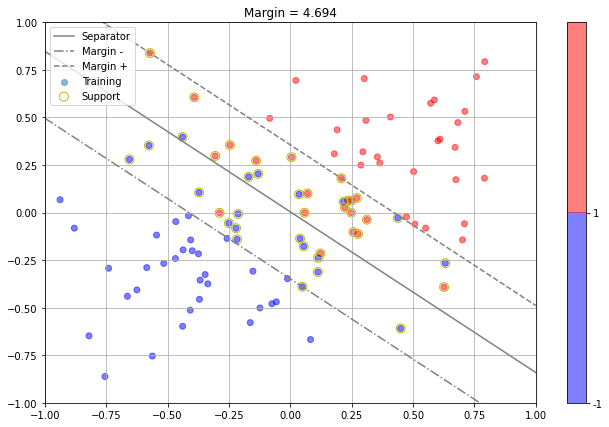

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, model11.support_vectors_, model11.coef_[0], model11.intercept_[0], 
        label='Training', ax=ax)

In [ ]:
model12 = linear_model.LogisticRegression(solver='lbfgs')
model12.fit(xTrain1, yTrain1)
model12.coef_[0], model12.intercept_[0]

(array([2.75469939, 2.88608714]), -0.1270489406465607)

In [ ]:
model13 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model13.fit(xTrain1, yTrain1)
model13.coef_[0], model13.intercept_[0]

(array([5.54944452, 6.36616234]), -0.20692806710240674)

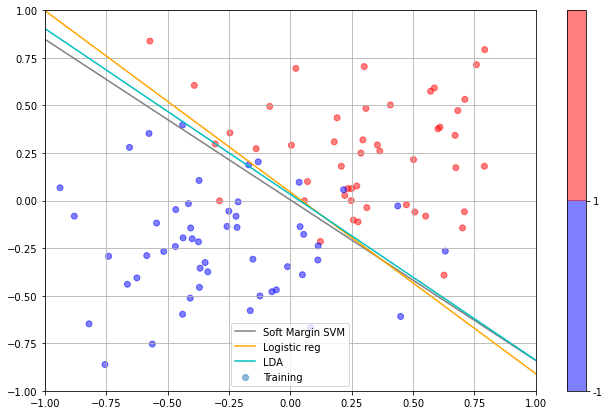

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, w=model11.coef_[0], intercept=model11.intercept_[0], label='Training',
        separatorLabel='Soft Margin SVM', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model12.coef_[0], x0=model12.intercept_[0], label='Logistic reg', color='orange')
plotLine(ax, xx, w=model13.coef_[0], x0=model13.intercept_[0], label='LDA', color='c')
ax.legend();

In [ ]:
xTest1, yTest1 = generateBatchBipolar(2*N, mu=0.3, sigma=0.3)

In [ ]:
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');

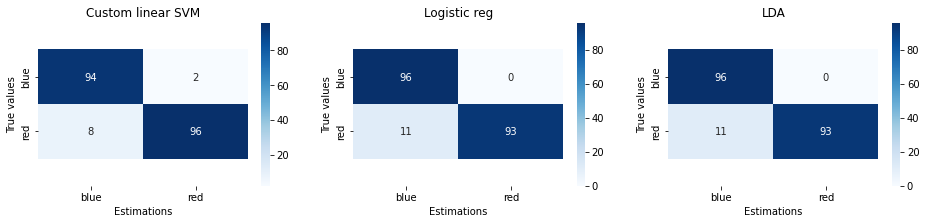

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3))
for model, ax, title in zip([model10, model12, model13], axes, ['Custom linear SVM', 'Logistic reg', 'LDA']):
    yEst = model.predict(xTest1)
    plotConfusionMatrix(yTest1, yEst, colors, title, ax=ax)

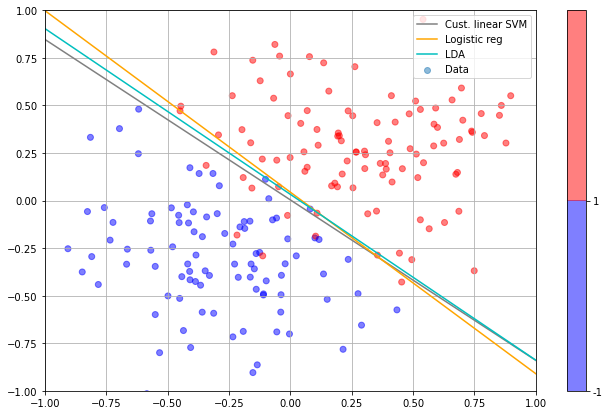

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTest1, yTest1, w=model10.w, intercept=model10.intercept, separatorLabel='Cust. linear SVM', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model12.coef_[0], x0=model12.intercept_[0], label='Logistic reg', color='orange')
plotLine(ax, xx, w=model13.coef_[0], x0=model13.intercept_[0], label='LDA', color='c')
ax.legend();

In [ ]:
def generateBatchXor(n, mu=0.5, sigma=0.5):
    """ Four gaussian clouds in a Xor fashion """
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:,0] *= y0
    X[:,1] *= y1
    X -= X.mean(axis=0)
    return X, y0*y1

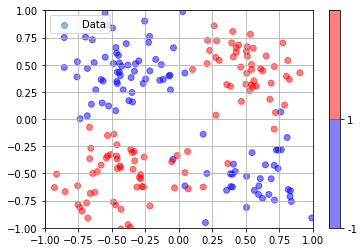

In [ ]:
xTrain3, yTrain3 = generateBatchXor(2*N, sigma=0.25)
plotSvm(xTrain3, yTrain3)
xTest3, yTest3 = generateBatchXor(2*N, sigma=0.25)

In [ ]:
model32 = linear_model.LogisticRegression(solver='lbfgs')
model32.fit(xTrain3, yTrain3)
model32.coef_[0], model32.intercept_[0]

(array([ 0.27965239, -0.51105675]), 0.12326105541121164)

In [ ]:
model33 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model33.fit(xTrain3, yTrain3)
model33.coef_[0], model33.intercept_[0]

(array([ 0.29925814, -0.54745279]), 0.12341181365859388)

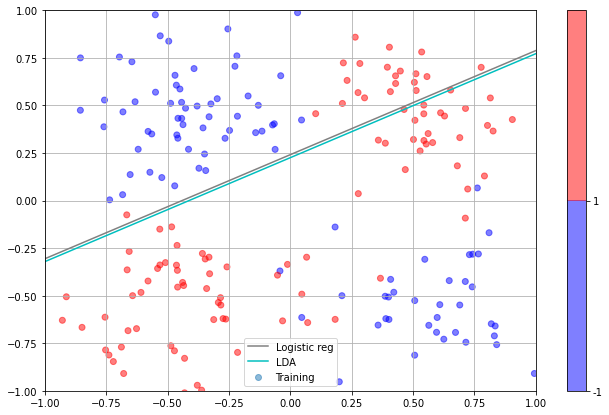

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, w=model32.coef_[0], intercept=model32.intercept_[0], label='Training',
        separatorLabel='Logistic reg', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model33.coef_[0], x0=model33.intercept_[0], label='LDA', color='c')
ax.legend();

In [ ]:
class KernelSvmClassifier:
    
    def __init__(self, C, kernel):
        self.C = C                               
        self.kernel = kernel          # <---
        self.alpha = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # --->
        # Gram matrix of h(x) y
        hXX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X),
                                  1, X)   
        yp = y.reshape(-1, 1)
        GramHXy = hXX * np.matmul(yp, yp.T) 
        # <---

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramHXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramHXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        # --->
        epsilon = 1e-8
        supportIndices = self.alpha > epsilon
        self.supportVectors = X[supportIndices]
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
        # <---
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        # --->
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, X)
        return 2 * (d > 0) - 1
        # <---

In [ ]:
def GRBF(x1, x2):
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * len(x1) / 2)

model30 = KernelSvmClassifier(C=5, kernel=GRBF)
model30.fit(xTrain3, yTrain3)

Number of support vectors = 37


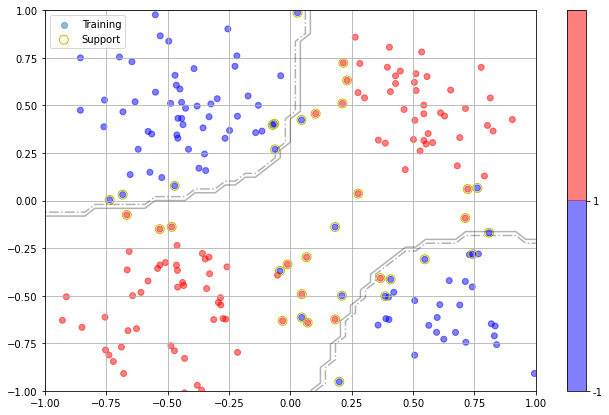

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=model30.supportVectors, label='Training', ax=ax)

# Estimate and plot decision boundary
xx = np.linspace(-1, 1, 50)
X0, X1 = np.meshgrid(xx, xx)
xy = np.vstack([X0.ravel(), X1.ravel()]).T
Y30 = model30.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y30, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

In [ ]:
model31 = svm.SVC(kernel='rbf', C=10, gamma=1/2, shrinking=False)
model31.fit(xTrain3, yTrain3);

Number of support vectors = 42


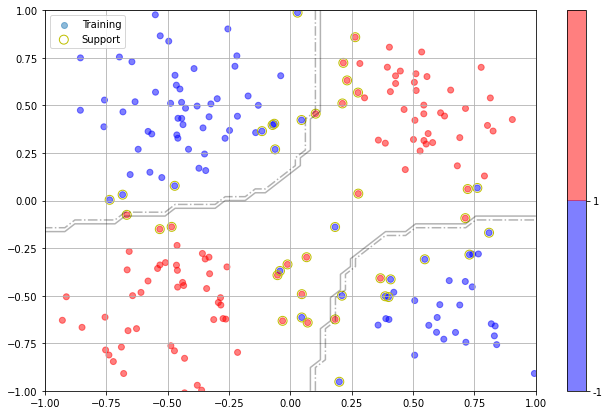

In [ ]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=model31.support_vectors_, label='Training', ax=ax)

# Estimate and plot decision boundary
Y31 = model31.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y31, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

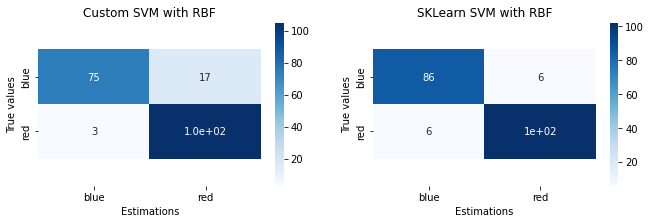

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))
for model, ax, title in zip([model30, model31], axes, ["Custom SVM with RBF", "SKLearn SVM with RBF"]):
    yEst3 = model.predict(xTest3)
    plotConfusionMatrix(yTest3, yEst3, colors, title, ax=ax)